In [1]:
import sys
sys.path.append('../..')
from src.pomdp import *

import pandas as pd
import numpy as np
import cupy as cp

## Model definition

In [2]:
nose_data = pd.read_csv('./Data/statistics_nose_3e6_35_153.dat', sep=',', header=None).values
nose_data = np.array(nose_data)

ground_data = pd.read_csv('./Data/statistics_ground_3e6_35_153.dat', sep=',', header=None).values
ground_data = np.array(ground_data)

In [3]:
# Model size
env_shape = nose_data.shape
state_count = env_shape[0] * env_shape[1]

print(f'Environment shape: {env_shape}')
print(f'State count: {state_count}')

Environment shape: (35, 153)
State count: 5355


In [7]:
ground_data.ravel().shape

(5355,)

In [9]:
# observation matrix
observations = np.empty((state_count, 6, 2))

observations[:,:5,0] = ground_data.ravel()[:,None]
observations[:,:5,1] = (1 - ground_data.ravel()[:,None])

observations[:,5,0] = nose_data.ravel()
observations[:,5,1] = (1 - nose_data.ravel())

In [5]:
# goal state
nose_data[17,0]

0.9988461538461538

In [10]:
def id_from_pos(x,y):
    return (x * env_shape[1]) + y

In [11]:
# states
state_grid = []

# State labels
for i in range(env_shape[0]):
    i_states = []
    for j in range(env_shape[1]):
        i_states.append(f's_{i}_{j}')

    state_grid.append(i_states)

In [14]:
# Reachable states
row_w = env_shape[1]

reachable_states = np.zeros((state_count, 6, 1), dtype=int)
for s in range(state_count):
    reachable_states[s,0,0] = s - row_w if s - row_w >= 0 else s # North
    reachable_states[s,1,0] = s + 1 if (s + 1) % row_w > 0 else s # East
    reachable_states[s,2,0] = s + row_w if s + row_w < state_count else s # South
    reachable_states[s,3,0] = s - 1 if (s - 1) % row_w < (row_w - 1) else s # West
    reachable_states[s,4,0] = s # Doesn't move and sniff ground
    reachable_states[s,5,0] = s # Doesn't move and sniff air

reachable_states = np.array(reachable_states)

In [15]:
# Reward function
def reward_func(s,a,sn,o):
    return np.where(sn == (17*env_shape[1]), 1.0, 0.0)

In [16]:
model = Model(
    states=state_grid,
    actions=['N','E','S','W','O_Ground','O_Air'],
    observations=['something', 'nothing'],
    reachable_states=reachable_states,
    rewards=reward_func,
    observation_table=observations,
    end_states=[id_from_pos(17,0)]
)

[10/17/2023, 17:54:27] Instantiation of MDP Model:
[10/17/2023, 17:54:27] - 5355 states
[10/17/2023, 17:54:27] - 6 actions
[10/17/2023, 17:54:27] - At most 1 reachable states per state-action pair
[10/17/2023, 17:54:27] - Starting generation of transitions table
[Warning] No transition matrix or function provided but reachable states are, so probability to reach any reachable states will "1 / reachable state count" so here: 1.000.
[10/17/2023, 17:54:27]     > Done in 0.000s
[10/17/2023, 17:54:27] - Generation of state grid
[10/17/2023, 17:54:27] - Generating start probabilities table
[10/17/2023, 17:54:27] - Starting computation of reachable state probabilities from transition data
[10/17/2023, 17:54:27]     > Done in 0.000s
[10/17/2023, 17:54:27] POMDP particular parameters:
[10/17/2023, 17:54:27] - 2 observations
[10/17/2023, 17:54:27] - Starting of transitional observations for reachable states table
[10/17/2023, 17:54:27]     > Done in 0.002s
[10/17/2023, 17:54:27] - Starting gener

## VI Solve

In [17]:
from src.mdp import VI_Solver

In [18]:
solver = VI_Solver(eps=1e-3)

In [19]:
solution, history = solver.solve(model, use_gpu=True)
print(history.summary)

[10/17/2023, 17:55:08] Sending Model to GPU...
[10/17/2023, 17:55:09]     > Done in 0.349s


  0%|          | 0/10000 [00:00<?, ?it/s]

Summary of Value Iteration run
  - Model: 5355-state, 6-action
  - Converged in 231 iterations and 0.1622 seconds
  - Took on average 0.0007s per iteration


[Warning] Value function on GPU, converting to numpy before plotting...
[Warning] 'as_grid' parameter set to False but state count is >3 so it will be plotted as a grid


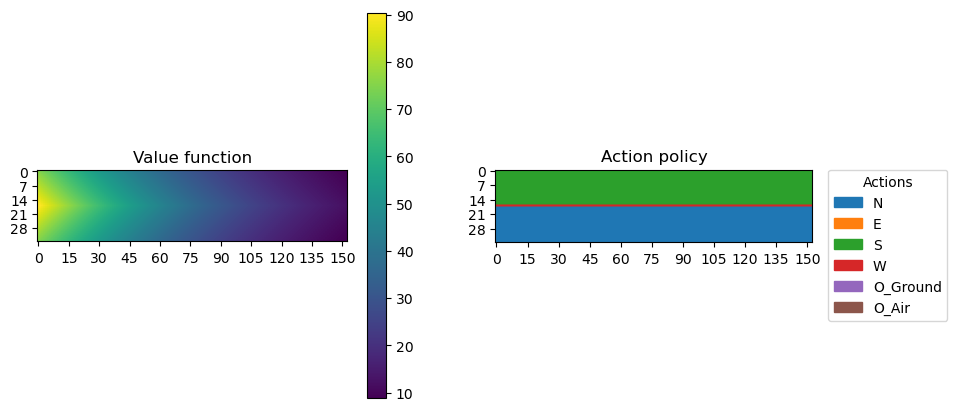

In [20]:
solution.plot()

## FSVI

In [21]:
fsvi_solver = FSVI_Solver(0.99, eps=1e-6)

In [22]:
fsvi_solution, hist = fsvi_solver.solve(model=model,
                                        expansions=300,
                                        horizon=300,
                                        mdp_policy=solution,
                                        belief_memory_depth=10,
                                        # prune_level=2, # Useless because of belief domination
                                        # prune_interval=25,
                                        # history_tracking_level=2,
                                        use_gpu=True)
print(hist.summary)

Expansions:   0%|          | 0/300 [00:00<?, ?it/s]

Summary of Value Iteration run
  - Model: 5355 state, 6 action, 2 observations
  - Converged or stopped after 300 expansion steps and 300 backup steps.
  - Converged in 97.3214s

  - Expand function took on average 0.0801s and yielded on average 88.24 beliefs per iteration.
  - Backup function took on average 0.2443s and yielded on average value functions of size 4532.06 per iteration.
  - Pruning function took on average 0.0000s and yielded on average prunings of 0.00 alpha vectors per iteration.


[Warning] Value function on GPU, converting to numpy before plotting...
[Warning] 'as_grid' parameter set to False but state count is >3 so it will be plotted as a grid


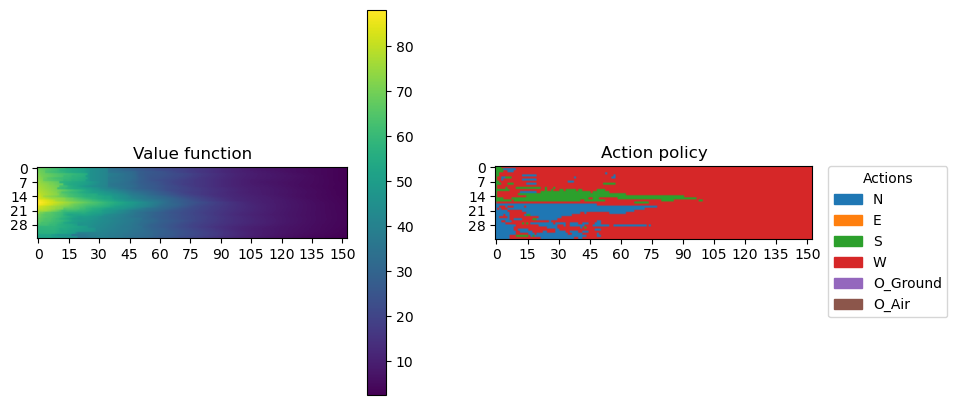

In [23]:
fsvi_solution.plot()